### Recommender example

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
sigmoid = lambda x: 1. / (1. + np.exp(-x))

In [4]:
is_numeric = lambda x: isinstance(x, (int, float, complex)) and not isinstance(x, bool)
# [(x, is_numeric(x)) for x in [0, 1, 2.345, 'hello', None, {12: 34}, [12, 23]]]

In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        layers = []
        for h in hidden_dims:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h
        layers.append(nn.Linear(input_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [6]:
# Ruben's version
class TwoTowerModel(nn.Module):
    def __init__(self, users, items, embedding_dim=2, hidden_dims=[], dtype=torch.float32, device='cpu'):
        """users and items dataframes with columns as features."""

        super().__init__()       
        assert users.notnull().all().all() and items.notnull().all().all()
        self.n_users, self.n_items, self.emb_dim = len(users), len(items), embedding_dim
        self.dtype, self.device = dtype, device

        # users, items
        self.id_embeddings = nn.ModuleList([nn.Embedding(self.n_users, embedding_dim), nn.Embedding(self.n_items, embedding_dim)])
        self.cat_embeddings = [nn.ModuleList(), nn.ModuleList()]  
        self.cat_metadata = [[], []]  # metadata
        self.cat_features = [[], []]  # users, items
        self.num_features = [[], []]  # users, items
        
        for i, df in enumerate([users, items]):
            for col in df:
                is_num = is_numeric(df[col].iloc[0])
                if is_num:
                    self.num_features[i].append(torch.tensor(df[[col]].values, dtype=dtype, device=self.device))
                else:
                    cat_ids, cat_names = df[col].factorize()
                    emb = nn.Embedding(len(cat_names), self.emb_dim)
                    self.cat_embeddings[i].append(emb)  # store emb as Module
                    self.cat_metadata[i].append({'i': i, 'emb': len(self.cat_embeddings[i]) - 1, 'feature': col, 'categories': cat_names})
                    self.cat_features[i].append(torch.tensor(cat_ids, dtype=torch.long).to(self.device))  # already torch

        self.towers = [
            MLP((1 + len(self.cat_embeddings[i])) * self.emb_dim + len(self.num_features[i]), hidden_dims, self.emb_dim)
            for i in [0, 1]]
        self.to(self.device)  # move model to device


    def forward(self, user_ids, item_ids):

        # Create towers
        vectors = []
        for i, ids in enumerate([user_ids, item_ids]):
            input = torch.cat(
                [self.id_embeddings[i](ids)] +
                [emb(features[ids]) for emb, features in zip(self.cat_embeddings[i], self.cat_features[i])] +
                [vals[user_ids] for vals in self.num_features[i]], dim=1)
            vectors.append(self.towers[i](input))

        # Cosine similarities
        vectors = [torch.nn.functional.normalize(v) for v in vectors]  # L2 norm for cosine similarities
        logits = (vectors[0] * vectors[1]).sum(dim=1)  
        return logits

In [7]:
dtype = torch.float32
# device = "cpu" 
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
torch.set_default_device(device)
print(f"Using {device} device")

Using mps device


In [8]:
# Simulate user and item interactions
n_users = 200  # 1000
n_items =  10  # 500
frac_imp = 1.  # only have interactions for % of all (user, item) pairs
n_imp = int(frac_imp * n_users * n_items)
true_emb_dim = 2  # using this to simulate true interests
print("See %.1f%% of all possible interactions." % (100. * n_imp / (n_users * n_items)))

# Simulate data (no features for now), using numpy
np.random.seed(123)
user_true_emb = np.random.randn(n_users, true_emb_dim)
item_true_emb = np.random.randn(n_items, true_emb_dim)
users, items = pd.DataFrame({'dummy': np.zeros(n_users)}), pd.DataFrame({'dummy': np.zeros(n_items)})
# genders = ['male', 'non-binary', 'female']
# users = pd.DataFrame({
#     'age': np.maximum(18, 40 + 15 * np.random.randn(n_users)).astype(int),
#     'gender': np.random.choice(genders, n_users, p=[.49, .49, .02]),
# })
# topics = ['food', 'culture', 'civics', 'sports', 'science', 'business']  # just random categories
# items = pd.DataFrame({
#     'topic': np.random.choice(topics, n_items),  # uniform distribution
# })

# cat_features = [genders, topics]
# cat_emb = {category: np.random.randn(true_emb_dim) for feature in cat_features for category in feature}
# emb = np.random.randn(n_users, true_emb_dim) \
#     + (users['age'] / users['age'].max()).values.reshape(-1, 1) \
#     + np.array(users['gender'].map(cat_emb).tolist())
# emb = (emb - emb.mean(axis=1).reshape(-1, 1)) / emb.std(axis=1).reshape(-1, 1) 
# user_true_emb = emb 
# emb = np.random.randn(n_items, true_emb_dim) + np.array(items['topic'].map(cat_emb).tolist())
# emb = (emb - emb.mean(axis=1).reshape(-1, 1)) / emb.std(axis=1).reshape(-1, 1)
# item_true_emb = emb

p_true = sigmoid(user_true_emb.dot(item_true_emb.T))  # true proability of user i liking item j
print(p_true.shape, p_true.mean())

# Generate data to feed into model, using tensors
g = torch.Generator(device=device).manual_seed(123) # for reproducibility
# user_ids = torch.randint(0, n_users, (n_imp,), generator=g)  # this includes (user, item) duplicate pairs, so does not work as well
# item_ids = torch.randint(0, n_items, (n_imp,), generator=g)
user_ids = torch.cat([torch.full((n_items,), i) for i in range(n_users)])[:n_imp]
item_ids = torch.cat([torch.arange(n_items)] * n_users)[:n_imp]
labels = (torch.tensor(p_true, dtype=dtype, device=device)[user_ids, item_ids] > .5).type(dtype)  # deterministic
# labels = (torch.tensor(p_true).to(device)[user_ids, item_ids] > torch.rand(n_imp)).float()  # probabilitic (prob needs repeats)
print(labels.cpu().numpy().mean())
# labels

See 100.0% of all possible interactions.
(200, 10) 0.5045790386250327
0.498


In [9]:
# torch hyperparameters
lr = 0.01
n_epochs = 300
n_print = 10

In [10]:
print(true_emb_dim)

2


In [11]:
# user_ids[test_idx]

In [12]:
torch.manual_seed(134)
model = TwoTowerModel(users, items, embedding_dim=2, hidden_dims=[], device=device)

# Training
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train / test split
frac_test = .1
test_idx = torch.rand(n_imp).to(device) < frac_test
train_idx = ~test_idx

# Training loop
stats = []
stop_epoch_delay = 1 * n_epochs // n_print
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    uids, iids = user_ids[train_idx], item_ids[train_idx]
    outputs = model.forward(uids, iids)
    loss = criterion(outputs, labels[train_idx])

    test_outputs = model.forward(user_ids[test_idx], item_ids[test_idx])
    test_loss = criterion(test_outputs, labels[test_idx])
    
    loss.backward()
    optimizer.step()
    
    stats.append({'epoch': epoch, 'loss': loss.item(), 'test loss': test_loss.item()})
    if epoch % (n_epochs // n_print) == 0:
        print(f"Epoch {epoch+1:4}, Loss: {loss.item():.4f}, Test loss: {test_loss.item():.4f}")

    if len(stats) > stop_epoch_delay and stats[-stop_epoch_delay]['test loss'] > stats[-stop_epoch_delay - 1]['test loss']:
        stats[-stop_epoch_delay - 1]['stop'] = True
        break
stats[-1]['stop'] = True        
stats = pd.DataFrame(stats).set_index('epoch')

Epoch    1, Loss: 0.7517, Test loss: 0.7424
Epoch   31, Loss: 0.7178, Test loss: 0.7436


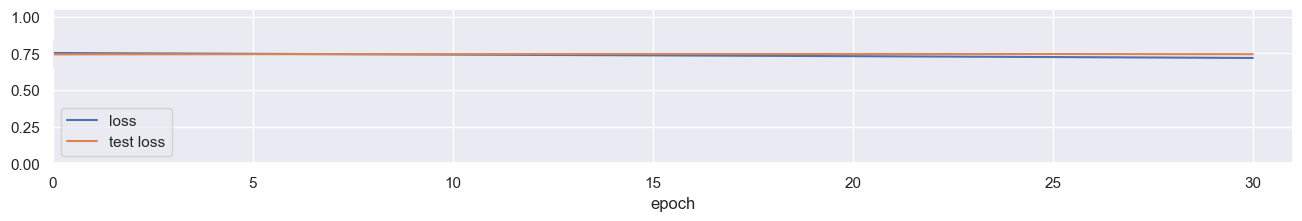

In [13]:
ax = stats.plot(figsize=(16, 2))
x = stats['stop'].dropna().index[0]
ax.vlines(x, stats['loss'][x] - .1, stats['test loss'][x] + .1, lw=.5, color='k')
_ = ax.set_xlim(0, len(stats)), ax.set_ylim(0, 1.05 * stats.max().max())

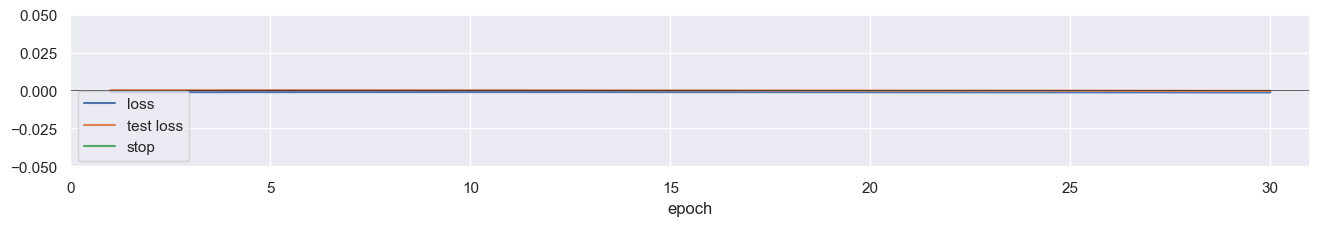

In [14]:
df = stats.diff()
ax = df.plot(figsize=(16, 2))
ax.axhline(0, lw=.5, color='k')
ax.vlines(x, df['loss'][x] - .01, df['test loss'][x] + .01, lw=.5, color='k')
_ = ax.set_xlim(0, len(stats)), ax.set_ylim(df.min().min() - .05, df.max().max() + .05)

In [15]:
y_pred = sigmoid(outputs.cpu().detach().numpy()).round(2)
y = labels[train_idx].cpu().detach().numpy()

print('prev ', labels.cpu().detach().numpy().mean())
print('train auc %.4f  acc %.4f  p %.4f  r %.4f' % 
      (roc_auc_score(y, y_pred), (y_pred.astype(int) == y).mean(), y_pred[y.astype(bool)].mean(), y[y_pred.astype(bool)].mean()))

y_pred = sigmoid(test_outputs.cpu().detach().numpy()).round(2)
y = labels[test_idx].cpu().detach().numpy()
print('test  auc %.4f  acc %.4f  p %.4f  r %.4f' % 
      (roc_auc_score(y, y_pred), (y_pred.astype(int) == y).mean(), y_pred[y.astype(bool)].mean(), y[y_pred.astype(bool)].mean()))

prev  0.498
train auc 0.5498  acc 0.5025  p 0.5524  r 0.4975
test  auc 0.4998  acc 0.4975  p 0.5425  r 0.5025
